In [41]:
import gym
import torch
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [42]:
class REINFORCE(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.policy_net = nn.Sequential(
            nn.Linear(state_dim, 64), nn.LeakyReLU(),
            nn.Linear(64, 32), nn.LeakyReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)  # 행동 확률 분포 출력
        )

    def forward(self, state):
        return self.policy_net(state)

In [43]:
class REINFORCEAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = REINFORCE(state_dim, action_dim).to(self.device)
        self.value_net = nn.Sequential(
            nn.Linear(state_dim, 64), nn.LeakyReLU(),
            nn.Linear(64, 32), nn.LeakyReLU(),
            nn.Linear(32, 1)  # 상태 가치 함수 V(s) 추정
        ).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)
        self.episode_log = []  # (log_prob, reward) 저장

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        probs = self.model(state_tensor)

        # log_prob 계산 (안정성 확보)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)

        return action.item(), log_prob  # 액션과 log 확률 반환

    def store_transition(self, log_prob, reward, state):
        state = torch.tensor(state, dtype=torch.float32)  # numpy 배열을 텐서로 변환
        self.episode_log.append((log_prob, reward, state))

    def compute_discounted_rewards(self, rewards):
        rewards = np.array(rewards, dtype=np.float32)
        discounts = np.power(self.gamma, np.arange(len(rewards)))
        return np.cumsum(rewards[::-1] * discounts[::-1])[::-1]

    def train(self):
        if not self.episode_log:
            return

        # NumPy로 보상 배열 변환
        # NumPy 벡터 연산으로 할인 보상 G_t 계산
        # Normalize rewards (옵션, 학습 안정성을 위해)
        rewards_np = np.array([reward for _, reward, _ in self.episode_log], dtype=np.float32)
        rewards_np = self.compute_discounted_rewards(rewards_np)
        rewards_np = rewards_np.copy()
        rewards = torch.tensor(rewards_np, dtype=torch.float32).to(self.device)

        states = torch.stack([state for _, _, state in self.episode_log]).to(self.device)
        baselines = self.value_net(states).squeeze(1)  # V(s)

        # Advantage 계산
        # Policy Gradient 손실 계산
        advantages = rewards - baselines.detach()  # (G_t - V(s_t))
        log_probs = torch.stack([log_prob for log_prob, _, _ in self.episode_log])
        total_policy_loss = (-log_probs * advantages).sum()

        # Value Function 손실 계산 (MSE Loss)
        value_loss = nn.functional.mse_loss(baselines, rewards)

        # 정책 네트워크 업데이트
        self.optimizer.zero_grad()
        total_policy_loss.backward(retain_graph=True)  # 그래디언트 유지
        self.optimizer.step()

        # 가치 네트워크 업데이트
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        self.episode_log = []  # 로그 초기화

In [44]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [45]:
# 환경 설정
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = REINFORCEAgent(state_dim, action_dim)
agent.model.apply(initialize_weights)
agent.value_net.apply(initialize_weights)

episodes = 1000
rewards_log = []

# 학습 실행
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0

    for _ in range(500):
        action, log_prob = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated) or bool(truncated)

        agent.store_transition(log_prob, reward, state)
        state = next_state
        total_reward += reward

        if done:
            break

    if np.mean(rewards_log[-10:]) < 450:
        agent.train()  # 에피소드 종료 후 학습

    rewards_log.append(total_reward)

env.close()

100%|██████████| 1000/1000 [04:29<00:00,  3.71it/s]


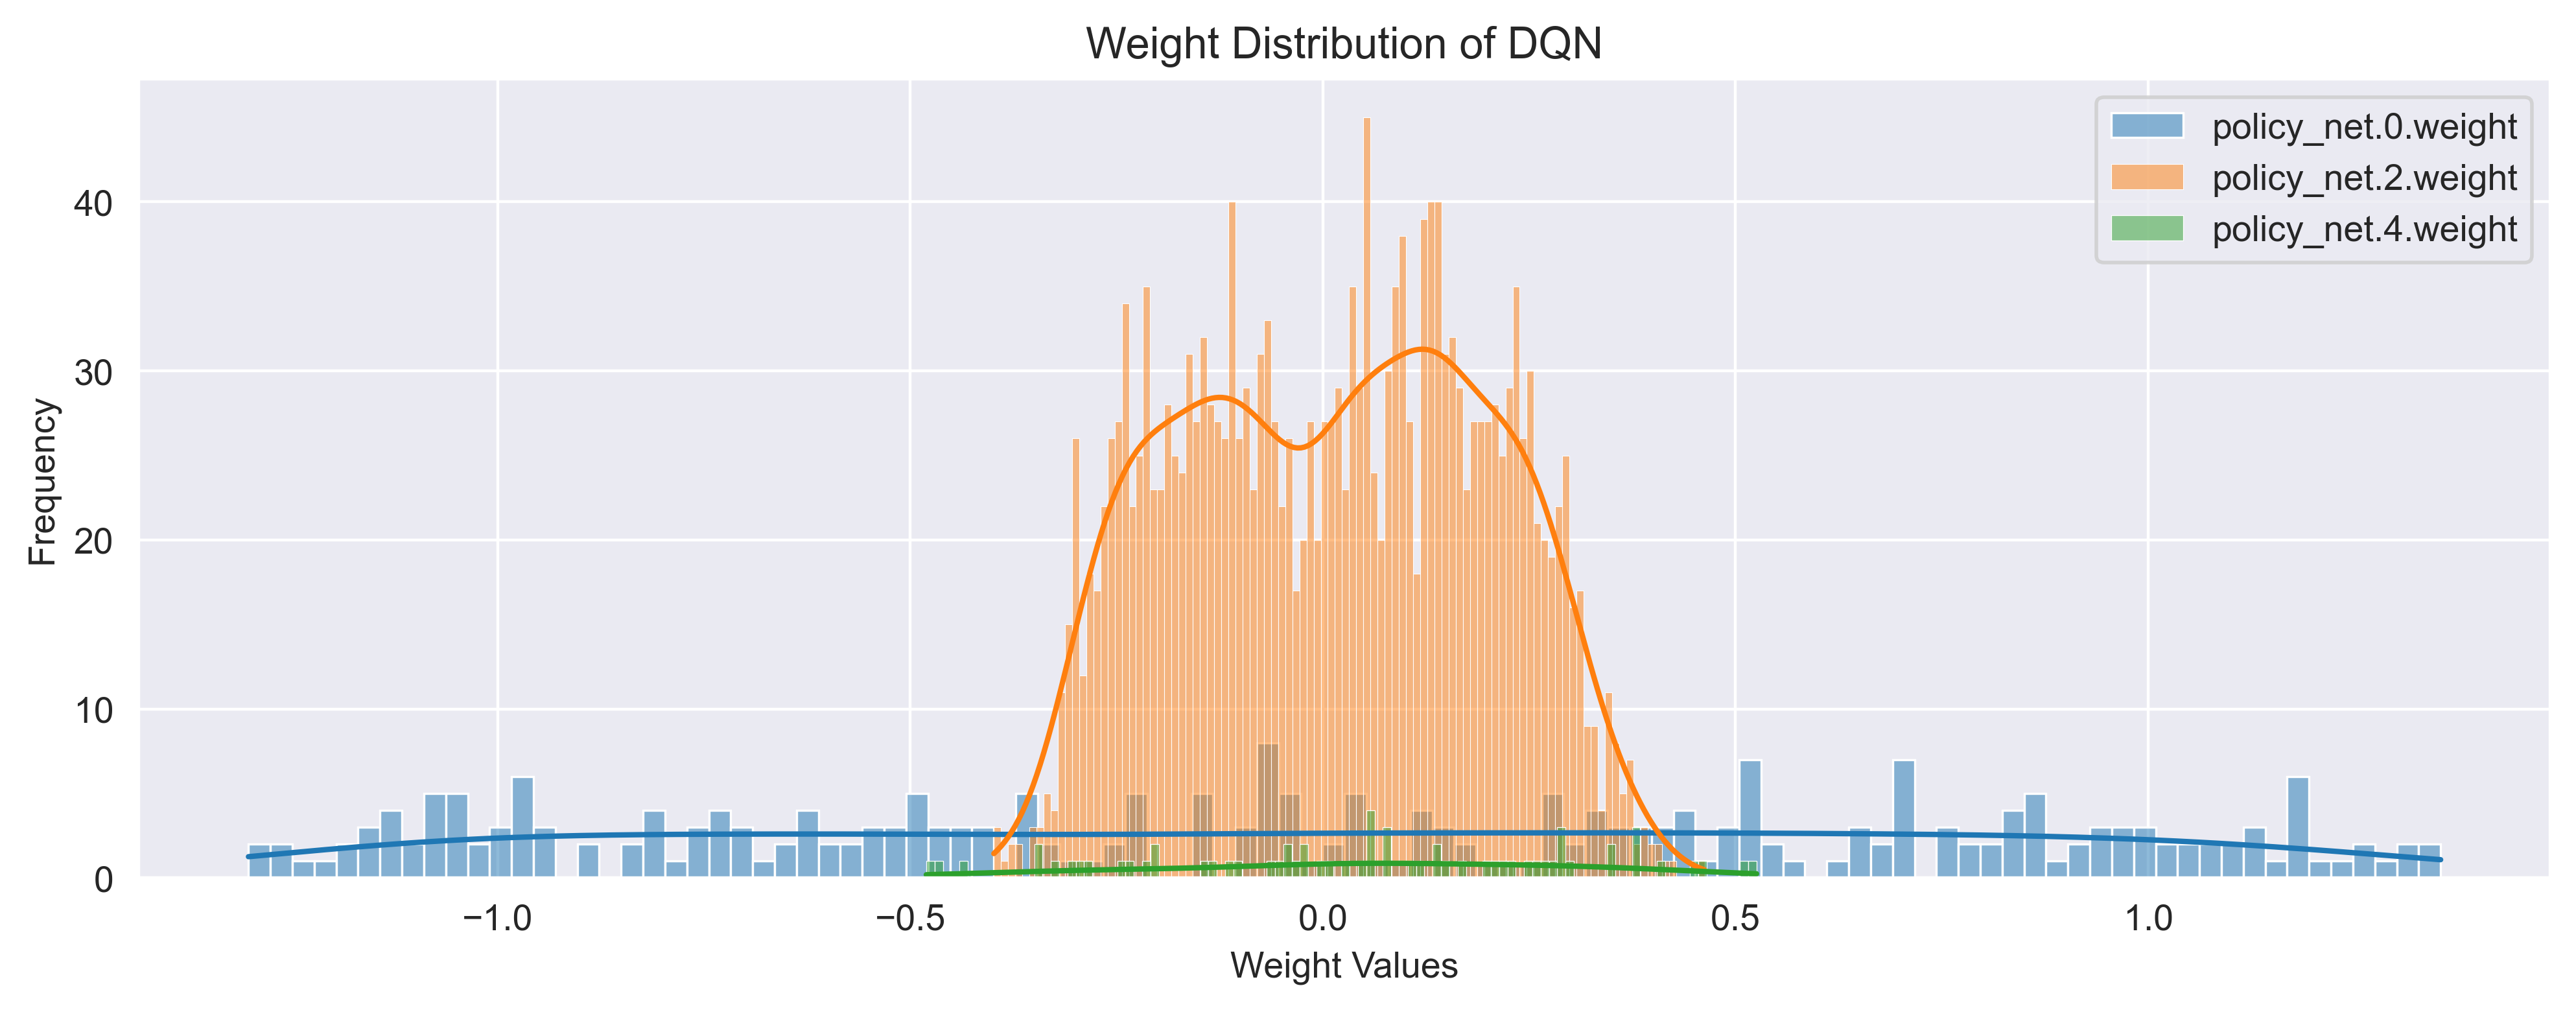

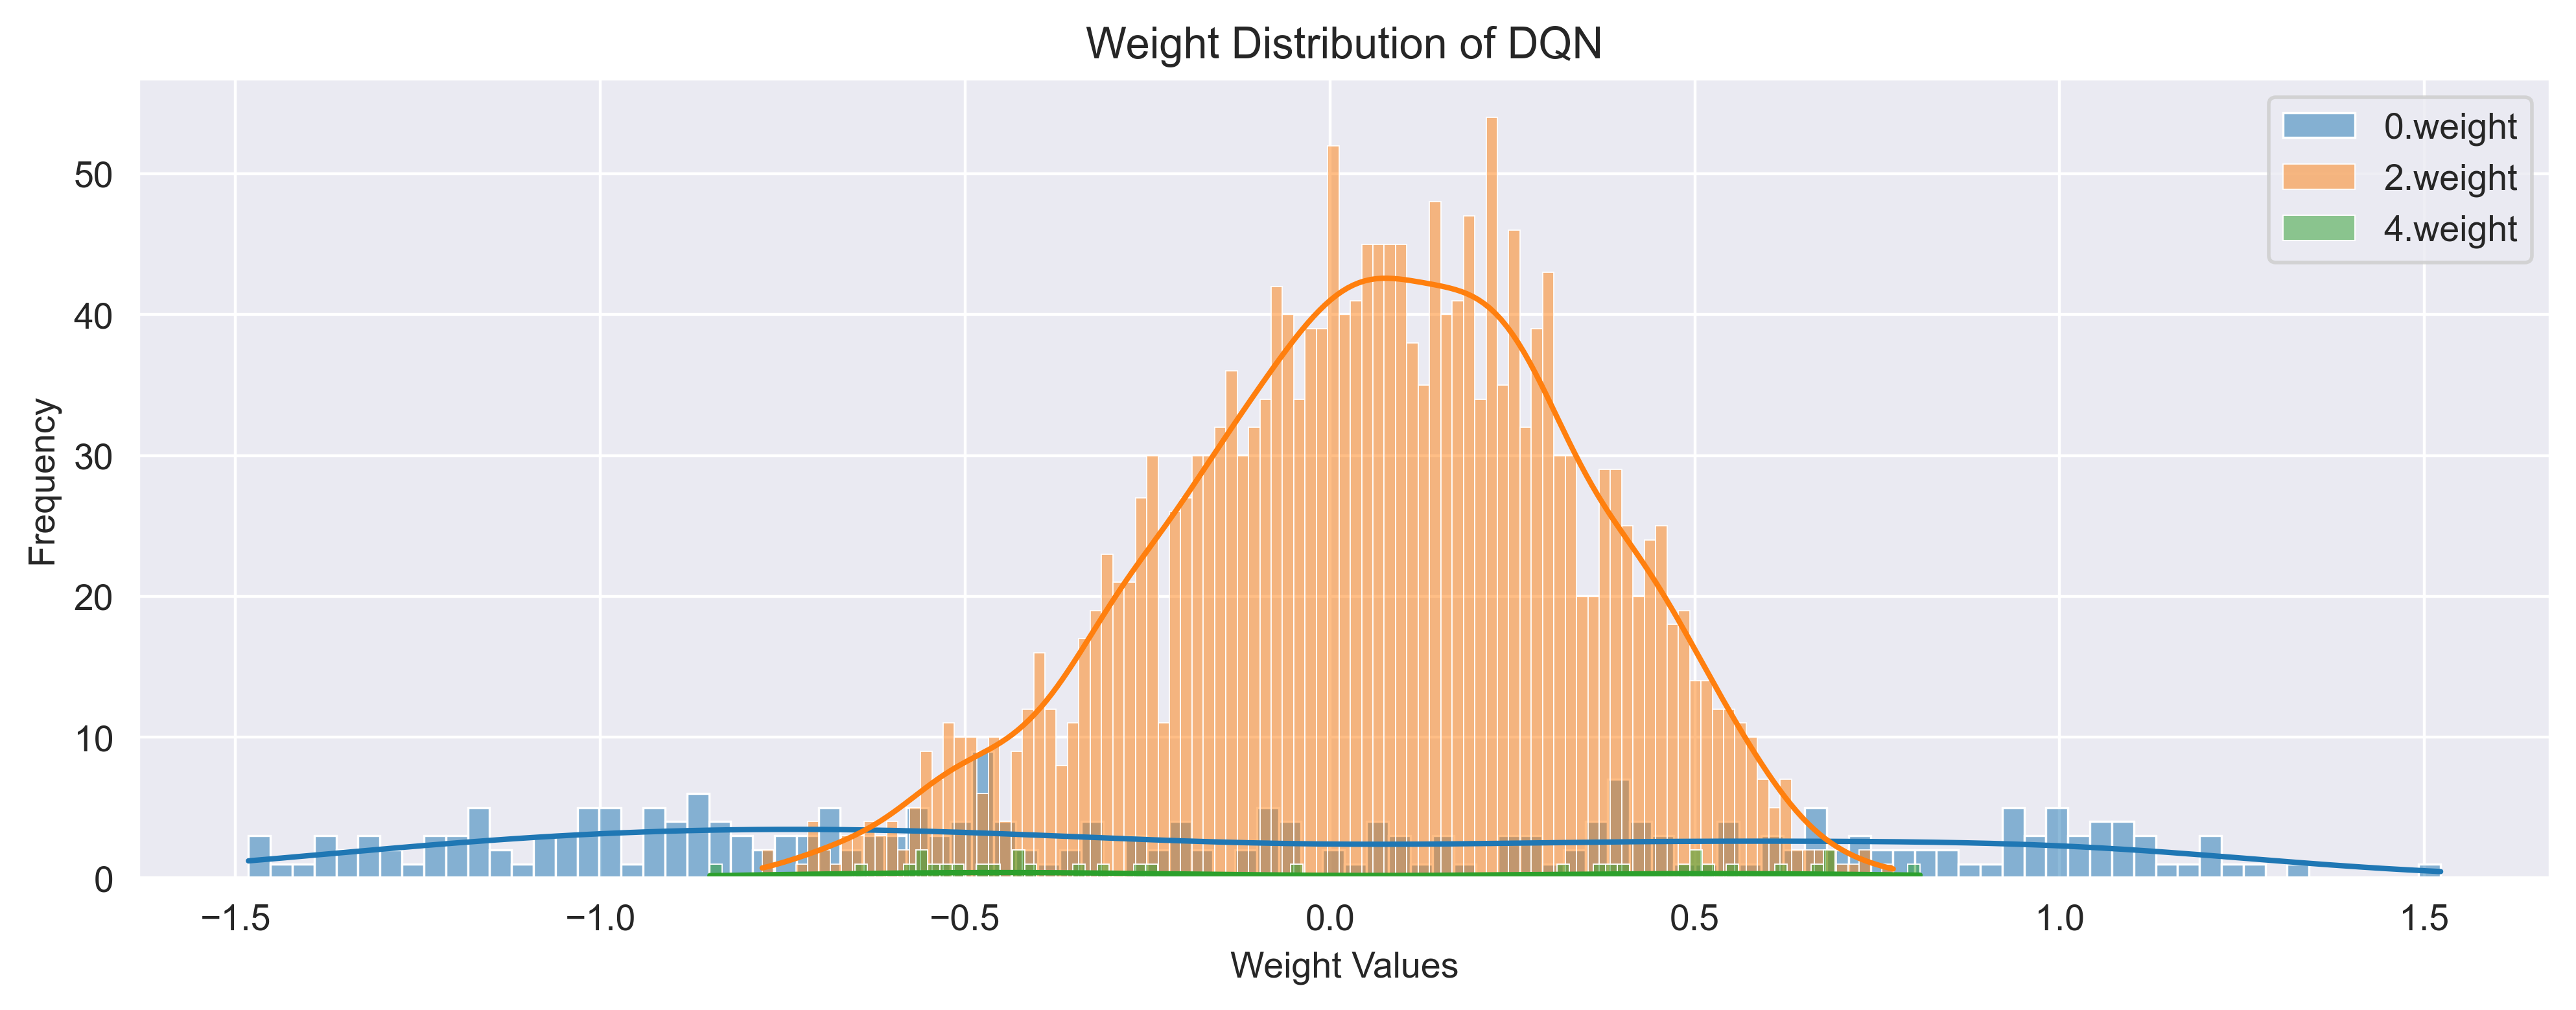

In [46]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(agent.model)
plot_weight_distribution(agent.value_net)

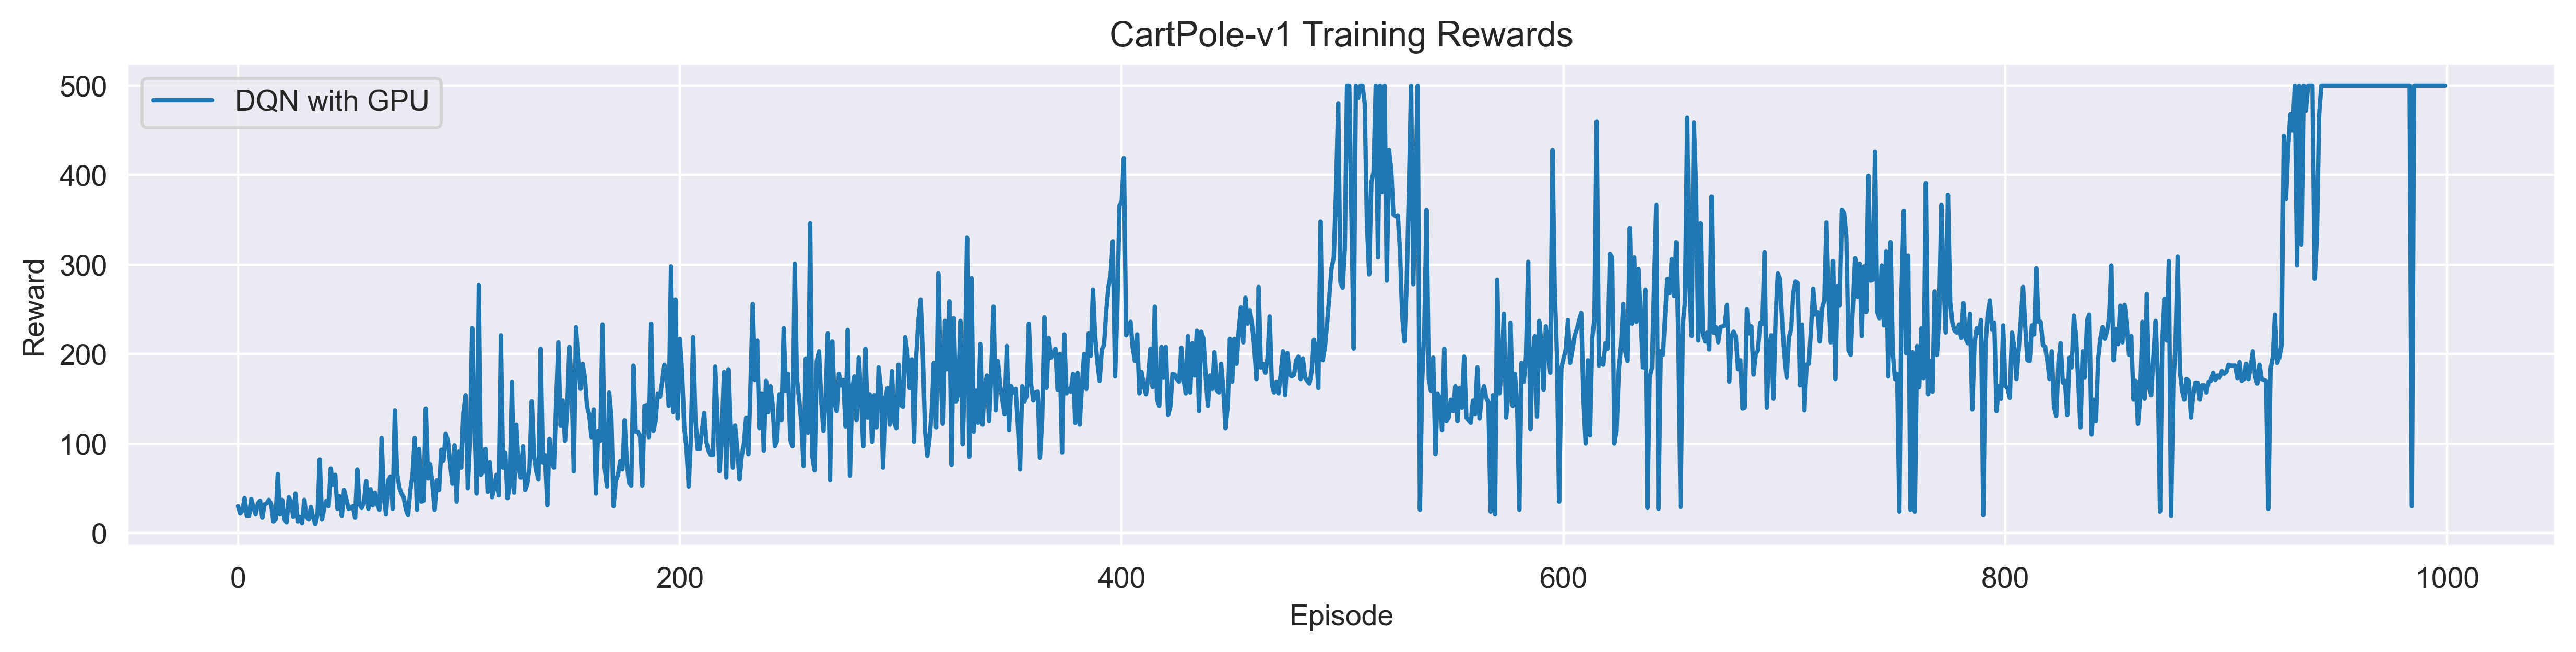

First 10 episode rewards: [30.0, 22.0, 25.0, 39.0, 19.0, 19.0, 38.0, 28.0, 21.0, 33.0]
Last 10 episode rewards: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Average reward over last 100 episodes: 400.45


In [47]:
# 학습 결과 시각화
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(rewards_log, label="DQN with GPU")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 Training Rewards")
plt.legend()
plt.show()

print("First 10 episode rewards:", rewards_log[:10])
print("Last 10 episode rewards:", rewards_log[-10:])
print(f"Average reward over last 100 episodes: {np.mean(rewards_log[-100:]):.2f}")